# Random Forest


In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt


#------------------------ Load and preprocess the data ------------------------


df1 = pd.read_csv('/content/drive/MyDrive/Sensors/postgres_new_data.csv')

df2 = pd.read_csv('/content/drive/MyDrive/Sensors/postgres_dati_aggiornati.csv')

df = pd.concat([df1, df2], ignore_index=True)

# Generate the column names as rv1, rv2, ..., rv1500
col_names = [f'rv{i}' for i in range(1, 1501)]

# Split the rv column by comma into a list of Series
split_series = df['rv'].str.split(',', n=1499, expand=True).apply(pd.Series)

# Concatenate the original DataFrame with the split Series
df = pd.concat([df, split_series], axis=1)

# Rename the split columns
df.rename(columns=dict(zip(split_series.columns, col_names)), inplace=True)

# Drop the original 'rv' column
df.drop('rv', axis=1, inplace=True)

df.head()

,tm,knt,ae,ae_cl,rv1,rv2,rv3,rv4,rv5,rv6,...,rv1491,rv1492,rv1493,rv1494,rv1495,rv1496,rv1497,rv1498,rv1499,rv1500
0,2022-10-13 03:38:11.838465,1500,0.109208,0,26.0026,25.0025,26.0026,26.0026,26.0026,26.0026,...,26.0026,26.0026,25.0025,26.0026,26.0026,26.0026,26.0026,25.0025,26.0026,26.0026
1,2022-10-13 13:30:49.852566,1500,0.317388,0,25.0025,25.0025,25.0025,25.0025,25.0025,25.0025,...,24.0024,25.0025,24.0024,25.0025,25.0025,25.0025,25.0025,25.0025,25.0025,25.0025
2,2022-10-13 14:17:07.820202,1500,0.300354,0,25.0025,25.0025,25.0025,25.0025,25.0025,25.0025,...,25.0025,25.0025,25.0025,25.0025,25.0025,25.0025,25.0025,25.0025,25.0025,25.0025
3,2022-09-07 23:13:37.665544,1500,0.179053,0,28.0028,28.0028,28.0028,28.0028,28.0028,28.0028,...,28.0028,28.0028,28.0028,28.0028,28.0028,28.0028,28.0028,28.0028,28.0028,28.0028
4,2022-09-07 23:25:58.593231,1500,0.300354,0,27.0027,28.0028,28.0028,28.0028,27.0027,28.0028,...,28.0028,28.0028,28.0028,28.0028,28.0028,28.0028,28.0028,28.0028,28.0028,28.0028


In [2]:
#------------------------ Define the features and labels ------------------------



X = df.loc[:, 'rv1':'rv1500'].astype(float).values
# X = df[col_names].astype(float).values
y = df['ae_cl']

# Create a mask that is True for non-nan values and False for nan values
mask = ~np.isnan(y)

# Apply the mask to both X and y
X = X[mask]
y = y[mask]

# Check the count of each class in y
print(np.unique(y, return_counts=True))


(array([0, 1, 2]), array([2189, 2743, 5000]))


# PCA

In [3]:
from sklearn.decomposition import PCA

"""
def plot_pca_variance(pca):
  # Plot the explained variances
  features = range(pca.n_components_)
  variance = pca.explained_variance_ratio_
  variance_cumu = np.cumsum(variance)
  plt.bar(features, variance)
  plt.xlabel('Principal Components')

  plt.ylabel('Explained variance')
  plt.title('Scree plot')
  plt.show()

  plt.plot(features, variance_cumu)
  plt.xlabel('Principal Components')
  plt.ylabel('Cumulative explained variance')
  plt.title('Cumulative scree plot')
  plt.show()

plot_pca_variance(pca)
"""

def reduce_features(X, n_components):
  data = X
  # define transform
  pca = PCA(n_components=n_components)
  # prepare transform on dataset
  pca.fit(data)
  # apply transform to dataset
  transformed = pca.transform(data)
  return transformed

transformed = reduce_features(X, 5)

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(transformed, y, test_size=0.2, random_state=42)

# Split the train set into train and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.25, random_state=42)


In [4]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

#------------------------ Create and train the model ------------------------

# Create and fit a random forest regressor
rfr = RandomForestRegressor(n_estimators=100, random_state=42)
rfr.fit(X_train, y_train.ravel()) # use ravel to flatten y_train

# Make predictions on the test set
y_pred = rfr.predict(X_test)


Root Mean Squared Error: 0.42
Mean Absolute Error: 0.28
Raw Accuracy: 0.72
Adjusted Accuracy: 0.78


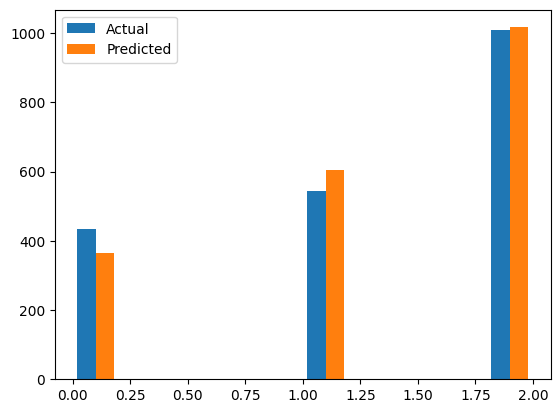

In [5]:
#------------------------ Analyze predictions for Test Set ------------------------

def evaluate_model(y_test, y_pred):
    # Evaluate the model performance
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    print(f"Root Mean Squared Error: {rmse:.2f}")

    # MAE
    mae = mean_absolute_error(y_test, y_pred)
    print(f"Mean Absolute Error: {mae:.2f}")

    # Accuracy
    accuracy = rfr.score(X_test, y_test)
    print(f"Raw Accuracy: {accuracy:.2f}")

    # Create new csv with actual and predicted data
    df = pd.DataFrame({'Actual': y_test, 'Predicted': np.round(y_pred, 0)})

    # Add the difference column
    df['Difference'] = df['Actual'] - df['Predicted']

    # Calculate accuracy of the model after rounding to the nearest integer
    accuracy = (df['Difference'] == 0.00).sum() / len(df)
    print(f"Adjusted Accuracy: {accuracy:.2f}")

    #------------------------ Plot predictions for Test Set ------------------------

    # Plot actual and predicted values with histogram
    plt.hist([df['Actual'], df['Predicted']], label=['Actual', 'Predicted'])
    plt.legend()
    plt.show()

evaluate_model(y_test, y_pred)

# Save the dataframe to a CSV file
df.to_csv('predictions_rf.csv', index=False)


Total predictions per class: (array([0., 1., 2.]), array([ 365,  605, 1017]))
Accuracy: 0.78
Accuracy by class: {1.0: 0.68, 2.0: 0.97, 0.0: 0.48}


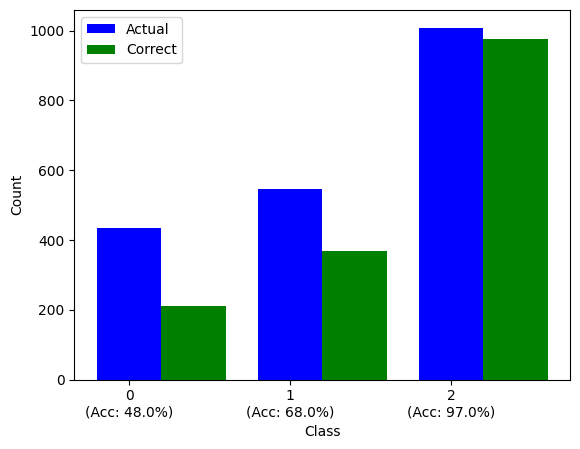

In [6]:
#------------------------ Analyze predictions for Test Set ------------------------
import matplotlib.pyplot as plt

def analyze_predictions(y_test, y_pred):
  # Create and print new df with actual and predicted value for test set
  df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred.round()})

  # Calculate difference between actual and predicted values
  df['Difference'] = (df['Actual'] - df['Predicted'])

  # save the new df
  df.to_csv('predictions_pca.csv')

  # Check the count of each class in df['Predicted']
  print("Total predictions per class:", np.unique(df['Predicted'], return_counts=True))

  # Calculate accuracy by comparing difference = 0 with total count
  accuracy = (df['Difference'] == 0).sum() / len(df)
  print("Accuracy:", accuracy.round(2))

  # For each row in df, check if difference = 0 and then increment count per class
  accuracy_by_class = {}
  for index, row in df.iterrows():
    if row['Difference'] == 0:
      if row['Actual'] in accuracy_by_class:
        accuracy_by_class[row['Actual']] += 1
      else:
        accuracy_by_class[row['Actual']] = 1

  # Get the total count of each class from the actual column
  class_count = df['Actual'].value_counts()

  # Loop through the dictionary and divide by the class count
  for key, value in accuracy_by_class.items():
    accuracy_by_class[key] = (value / class_count[key]).round(2)

  # Print accuracy by class
  print("Accuracy by class:", accuracy_by_class)

  # Get the unique classes from the actual column
  classes = np.unique(df['Actual'])

  # Create a figure and a subplot
  fig, ax = plt.subplots()

  # Loop through the classes
  for c in classes:
    # Filter the rows where the actual class is c
    df_c = df[df['Actual'] == c]
    # Plot the actual values as blue bars
    # Use label only for the first class
    if c == classes[0]:
      ax.bar(c - 0.2, len(df_c), width=0.4, color='blue', label='Actual', align='edge')
    else:
      ax.bar(c - 0.2, len(df_c), width=0.4, color='blue', align='edge')
    # Filter the rows where the difference is zero (correct predictions)
    df_c_correct = df_c[df_c['Difference'] == 0]
    # Plot the correct predictions as green bars
    # Use label only for the first class
    if c == classes[0]:
      ax.bar(c + 0.2, len(df_c_correct), width=0.4, color='green', label='Correct', align='edge')
    else:
      ax.bar(c + 0.2, len(df_c_correct), width=0.4, color='green', align='edge')

  # Set the x-axis ticks and labels to the classes
  ax.set_xticks(classes)
  # Create a list of labels with the accuracy values
  labels = [f"{c}\n(Acc: {accuracy_by_class[c]*100}%)" for c in classes]
  # Set the x-axis labels to the new labels
  ax.set_xticklabels(labels)

  # Set the x-axis and y-axis labels
  ax.set_xlabel('Class')
  ax.set_ylabel('Count')

  # Add a legend
  ax.legend()

  # Show the plot
  plt.show()

analyze_predictions(y_test, y_pred)


Root Mean Squared Error: 0.40
Mean Absolute Error: 0.27
Raw Accuracy: -0.76
Adjusted Accuracy: 0.79


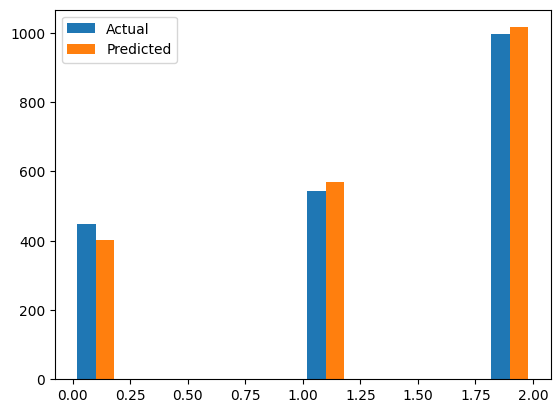

In [7]:
#------------------------ Analyze predictions for Validation Set ------------------------

# Make predictions on the test set
y_pred = rfr.predict(X_valid)

evaluate_model(y_valid, y_pred)

# Save the dataframe to a CSV file
df.to_csv('predictions_rf.csv', index=False)


Total predictions per class: (array([0., 1., 2.]), array([ 403,  568, 1016]))
Accuracy: 0.79
Accuracy by class: {2.0: 0.98, 1.0: 0.64, 0.0: 0.53}


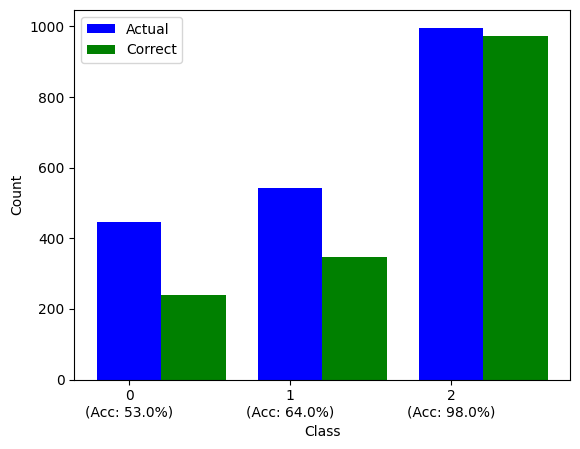

In [8]:
#------------------------ Analyze predictions for Validation Set ------------------------

analyze_predictions(y_valid, y_pred)

# Results

Without PCA and no valid_set: 75%
Class 0: 42%
Class 1: 65%
Class 2: 94%

With PCA and no valid_set: 78%
Class 0: 47%
Class 1: 67%
Class 2: 97%

Without PCA and with valid_set: 75%
Class 0: 48%
Class 1: 61%
Class 2: 94%

✅With PCA and with valid_set: 79%
Class 0: 53%
Class 1: 64%
Class 2: 98%



Total predictions per class: (array([0., 1., 2.]), array([ 403,  568, 1016]))
Accuracy: 0.79
Recall by class: {2.0: 1.0, 1.0: 0.92, 0.0: 0.55}


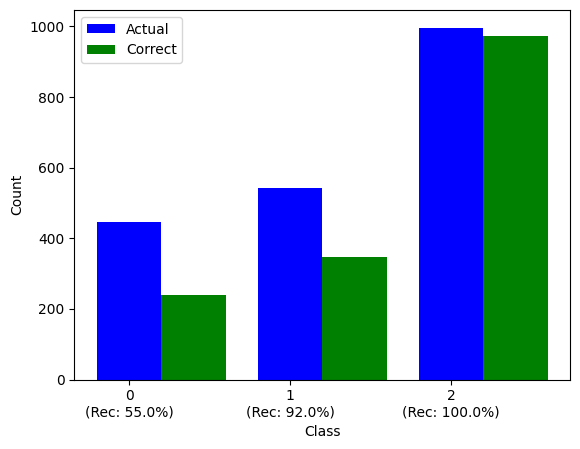

In [9]:
#------------------------ Calculate Recall for Validation Set  ------------------------

# Recall is calculated as follows: Recall=True Positives/(False Negatives+True Positives​)

# Create and print new df with actual and predicted value for test set
df = pd.DataFrame({'Actual': y_valid, 'Predicted': y_pred.round()})

# Calculate difference between actual and predicted values
df['Difference'] = (df['Actual'] - df['Predicted'])

# save the new df
df.to_csv('predictions_pca.csv')

# Check the count of each class in df['Predicted']
print("Total predictions per class:", np.unique(df['Predicted'], return_counts=True))

# Calculate accuracy by comparing difference = 0 with total count
accuracy = (df['Difference'] == 0).sum() / len(df)
print("Accuracy:", accuracy.round(2))

# For each row in df, check if difference = 0 and then increment count per class
# Also check if difference = -1 and then increment false negatives per class
recall_by_class = {}
false_negatives_by_class = {}
for index, row in df.iterrows():
  if row['Difference'] == 0:
    if row['Actual'] in recall_by_class:
      recall_by_class[row['Actual']] += 1
    else:
      recall_by_class[row['Actual']] = 1
  if row['Difference'] == -1:
    if row['Actual'] in false_negatives_by_class:
      false_negatives_by_class[row['Actual']] += 1
    else:
      false_negatives_by_class[row['Actual']] = 1

# Loop through the dictionary and divide by the class count
for key, value in recall_by_class.items():
  # Get the number of false negatives for the key, or 0 if not found
  fn = false_negatives_by_class.get(key, 0)
  # Calculate the recall by class
  recall_by_class[key] = (value / (value + fn))

# Print recall by class
# Round each value to 2 decimal places
recall_by_class = {k: round(v, 2) for k, v in recall_by_class.items()}

print("Recall by class:", recall_by_class)

# Get the unique classes from the actual column
classes = np.unique(df['Actual'])

# Create a figure and a subplot
fig, ax = plt.subplots()

# Loop through the classes
for c in classes:
  # Filter the rows where the actual class is c
  df_c = df[df['Actual'] == c]
  # Plot the actual values as blue bars
  # Use label only for the first class
  if c == classes[0]:
    ax.bar(c - 0.2, len(df_c), width=0.4, color='blue', label='Actual', align='edge')
  else:
    ax.bar(c - 0.2, len(df_c), width=0.4, color='blue', align='edge')
  # Filter the rows where the difference is zero (correct predictions)
  df_c_correct = df_c[df_c['Difference'] == 0]
  # Plot the correct predictions as green bars
  # Use label only for the first class
  if c == classes[0]:
    ax.bar(c + 0.2, len(df_c_correct), width=0.4, color='green', label='Correct', align='edge')
  else:
    ax.bar(c + 0.2, len(df_c_correct), width=0.4, color='green', align='edge')

# Set the x-axis ticks and labels to the classes
ax.set_xticks(classes)
# Create a list of labels with the recall values
labels = [f"{c}\n(Rec: {round(recall_by_class[c]*100, 2)}%)" for c in classes]
# Set the x-axis labels to the new labels
ax.set_xticklabels(labels)

# Set the x-axis and y-axis labels
ax.set_xlabel('Class')
ax.set_ylabel('Count')

# Add a legend
ax.legend()

# Show the plot
plt.show()


In [ ]:
# ------------------------ Save Model ------------------------
import joblib

# Save the model to a file
joblib.dump(rfr, "random_forest.joblib")


# ------------------------ Load and use Model ------------------------

# Load the model from the file
#loaded_rf = joblib.load("random_forest.joblib")

# Use the loaded model to make predictions
#loaded_rf.predict(X_test)
